# Sonification Demo

This notebook demonstrates how to "sonify" a simple data set, converting the data to an audio form to help us try to perceive patterns within that data.

The notebook makes use of the python *pandas* package to represent and *visualise* a dataset, as well as packages associated with the Jupyter notebook environment that support the audio playback as well as the embedding of interactive widgets that allow us to explore a dataset interactively.

### Setting Up the Notebook

Run the following code cells to set up the notebook environment.

In [1]:
#IPython package for embedding an audio player in a notebook
from IPython.display import Audio

#The ipwidgets.interact package supports interactive widget creation
from ipywidgets import interact

#Import a routine to plot simple datasets
from matplotlib.pyplot import plot

In [2]:
#Import the pandas package for working with tabular datasets
import pandas as pd

#Various packages that provide access to maths functions
import random
import numpy as np
import math

## Working With Audio

The following examples are based on a [sonification notebook](https://jupyter.brynmawr.edu/services/public/dblank/jupyter.cs/Sonification.ipynb) published by Doug Blank at Bryn Mawr College.

Let's start with a simple demonstration of how to create and play a simple tone (a sine wave). You do not need to understand how the code works in order to run the code cell.

If you want the audio player to play the tone automatically when the code cell is run, change the setting from `autoplay=False` to `autoplay=True`.

__Run the code cells below now.__

In [3]:
duration = 2 # duration of the tone in seconds
rate = 44100 # sampling rate of the tone

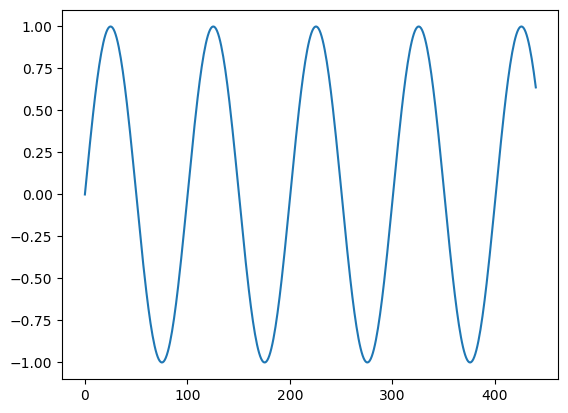

In [4]:
#https://jupyter.brynmawr.edu/services/public/dblank/jupyter.cs/Sonification.ipynb
#This rather complicated looking function creates a function
#It allows us to retrieve the value of a sine wave of a particular frequency at a particular time.
#The frequency is the frequency of the tone in hertz (hz)
def make_tone(frequency):
    def f(t):
        return math.sin(2 * math.pi * frequency * t)
    return f

tone440 = make_tone(440) 

#Visualise the tone over a short period (0.1s)
plot([tone440(t) for t in np.arange(0, .01, 1/rate)]);

#Generate the tone and play it through a notebook embedded audio player
Audio([tone440(t) for t in np.arange(0, duration, 1/rate)], rate=rate, autoplay=False)

## Sonifying Data

As well as playing simple tones, we can also generate audio signals of varying frequencies based on data values contained within a dataset.

We will create a couple of helper functions to generate an "audio" dataset from a 

In [5]:
# Function to find the value of a sine wave of a given frequency at a particular time
def make_tone2(t, frequency):
    return math.sin(2 * math.pi * frequency * t)

In [6]:
#Grab a list of frequency values from a dataset for playback over a given period at a given sampling rate
def makeAudio(data, duration, rate, minf=200, maxf=5000):
    audiodata=[]
    for t in np.arange(0, duration, 1/rate):
        data_index = math.floor(t/duration * len(data))
        ratio = (data[data_index] - min(data))/(max(data) - min(data))            
        audiodata.append(make_tone2(t, ratio * (maxf - minf) + minf)) 
    return audiodata

The `makeAudio()` function may take some time to run, so it makes sense to provide a means for saving and loading the data. 

In [7]:
def saveAudioData(data, outfile = "audiodata.txt"):
    ''' Function to save the audiodata list'''
    with open(outfile, "w") as f:
        for s in data:
            f.write(str(s) +"\n")

def loadAudioData(infile = "audiodata.txt"):
    readback = []
    with open(infile, "r") as f:
        for line in f:
            readback.append(line.strip())
    return readback

## Now It's Time to Sonify

Generate a sample dataset with several columns, each representing a set frequencies over time:

- a set of values that increase proportionally (linearly) over time;
- a set of values that decrease proportionally (linearly) over time;
- a set of values that increase proportionally (linearly) over time with the addition of random noise.

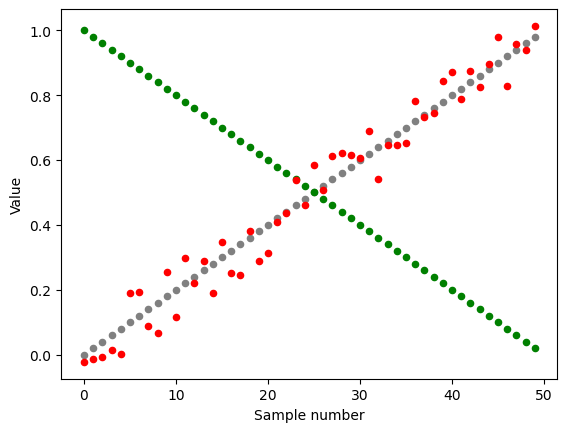

In [8]:
#Generate the dataset and preview it as a chart
numpoints = 50

df = pd.DataFrame({'x':np.arange(0, numpoints)})

#Generate a column with values proportional to time
df['y'] =  df['x'] / numpoints

#Generate a column with values inversely proportional to time
df['y2'] = 1 - df['y']

#Generate a column with values proportional to time with the addition of random noise
df['y3'] = df.apply(lambda x: x['y']+((random.random()/5) - 0.1), axis=1)

ax = df.plot(kind='scatter', x='x', y='y', color='grey')
df.plot(kind='scatter', x='x', y='y2', color='green', ax=ax)
df.plot(kind='scatter', x='x', y='y3', color='red', ax=ax)

ax.set_xlabel('Sample number')
ax.set_ylabel('Value');

In [9]:
minf=200 #Minimum frequency
maxf=4000 #Maximum frequency
duration = 2

Change the `col = ` setting to one of the other columns (`y`, `y2`, `y3`) to choose which set of data valus to visualise and sonify.

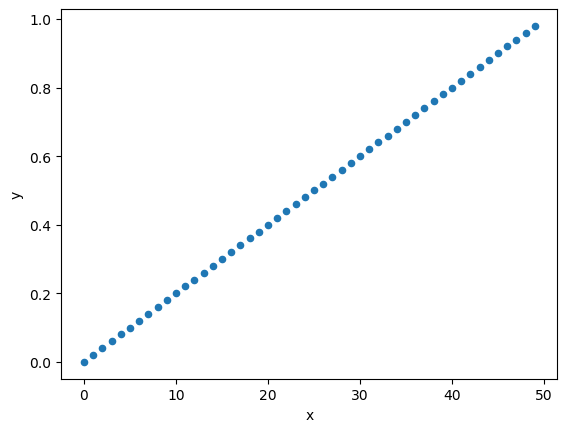

In [10]:
#Select a column to visualise and sonify
col = 'y'

df.plot(kind='scatter', x= 'x', y=col);
Audio(makeAudio(df[col], duration, rate, minf, maxf), rate=rate, autoplay=False)

## Visualising a more random scatterplot

In [11]:
#Example of reordering a list of numbers in a random order
nums = list(range(0,10))
random.shuffle(nums)
nums

[4, 6, 0, 2, 1, 8, 7, 3, 5, 9]

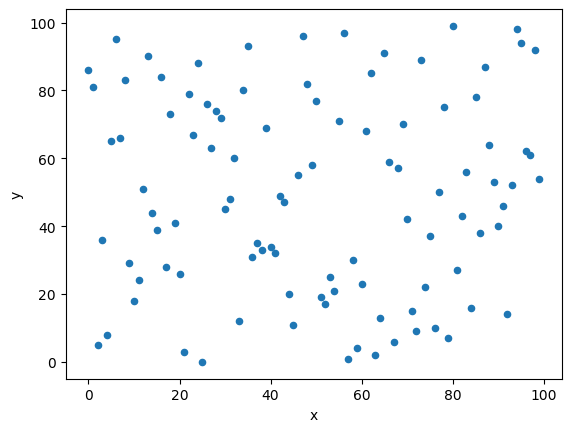

In [12]:
samples = 100

df = pd.DataFrame({'x':np.arange(0,samples)})
nums=list(range(0,samples))

random.shuffle(nums)
df['y'] = nums
df.plot(kind='scatter',x= 'x',y='y');

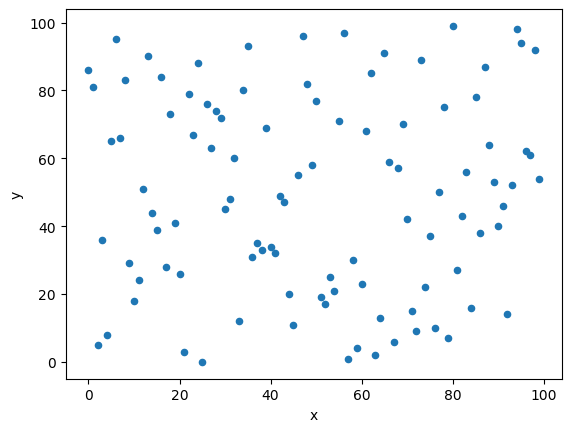

In [13]:
df.plot(kind='scatter',x= 'x',y='y');
Audio(makeAudio(df['y'], duration, rate), rate=rate, autoplay=False)

## Generating Scatterplots With a Specified Correlation

We can create a function that will generate scatterplots with a specified correlation.

We can then create an interactive scatterplot explorer that allows us to both visualise and sonify scatterplots with different correlations.

In [18]:
#ish via https://stackoverflow.com/a/18684433/454773
def generateCorrelatedData(correlation):
    ''' Function to create a two dimensional dataset with a specified correlation between values '''
    
    xmin=0
    xmax=100

    ymin=0
    ymax=1

    xx = np.array([xmin, xmax])
    yy = np.array([ymin, ymax])
    means = [xx.mean(), yy.mean()]

    #Set up the standard deviations so the half-interval corresponds to 3 standard deviations
    #This means ~99% of the generated points will be inside the interval
    stds = [xx.std() / 3, yy.std() / 3]

    #Create the correlated data
    covariances = [[stds[0]**2, stds[0]*stds[1]*correlation], [stds[0]*stds[1]*correlation, stds[1]**2]]
    m = np.random.multivariate_normal(means, covariances, 50)
    
    #Represent the data as a dataframe
    df = pd.DataFrame(m, columns=['x','y'])
    
    #Sort the dataframe by increasing x
    df = df.sort_values('x').reset_index()
    
    return df

We can now use that function as part of an interactive scatterplot explorer.

interactive(children=(FloatSlider(value=1.0, description='correlation', max=1.0, step=0.05), Output()), _dom_c…

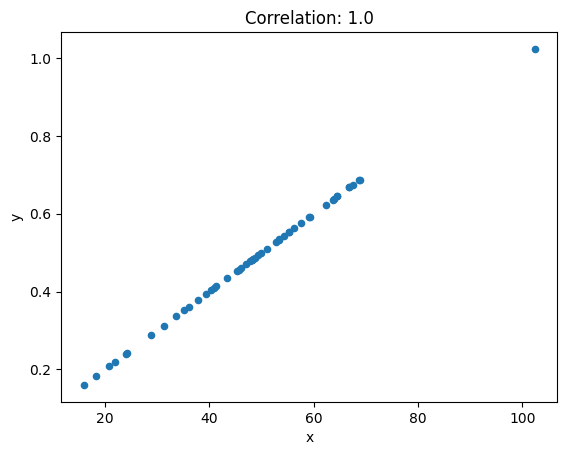

In [19]:
@interact(correlation=(0,1,0.05))
def correlatedScatter(correlation=1.0):
    df=generateCorrelatedData(correlation)
    df.plot(kind='scatter', x='x', y='y', title='Correlation: {}'.format(correlation));
    
    display(Audio(makeAudio(df['y'], duration, rate), rate=rate, autoplay=False))

## Saving the Audio File

As well as playing hthe audio file, we can also save it.

In [20]:
data=makeAudio(df['y'], duration, rate)

In [21]:
#Wav file generator based on the Jupyter notebook Audio._make_wav() component

import struct
from io import BytesIO
import wave

def saveWav(audio_data, filename='sonified.wav', returner=False):
    nchan = 1

    fp = BytesIO()

    maxvalue = np.max(np.abs(audio_data))
    scaled = np.int16(audio_data/maxvalue * 32767).tolist()

    waveobj = wave.open(fp, mode='wb')
    waveobj.setnchannels(nchan)
    waveobj.setframerate(rate)
    waveobj.setsampwidth(2)
    waveobj.setcomptype('NONE','NONE')
    waveobj.writeframes(b''.join([struct.pack('<h',x) for x in scaled]))
    
    val = fp.getvalue()
    
    waveobj.close()
    
    with open(filename,'wb') as out:
        out.write(val)
        
    if returner: return val

## Summary

This notebook has demonstrated how simple datasets can be "visualised" in an audible way using a technique referred to as a *sonification*.